### Load required modules

In [3]:
import numpy as np
import matplotlib
import pandas as pd # I only use pandas for plotting
%matplotlib inline

# Question 3

### 3.1. Generate the M and b

In [4]:
n = 100
M = np.diag(np.ones(n)*2) + np.diag(-np.ones(n-1),-1) + np.diag(-np.ones(n-1),1)
b = np.zeros(n)
b[0] = 1

In [5]:
M, b

(array([[ 2., -1.,  0., ...,  0.,  0.,  0.],
        [-1.,  2., -1., ...,  0.,  0.,  0.],
        [ 0., -1.,  2., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  2., -1.,  0.],
        [ 0.,  0.,  0., ..., -1.,  2., -1.],
        [ 0.,  0.,  0., ...,  0., -1.,  2.]]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [6]:
def f(x,m):
    return M.dot(x).dot(x)/2-b.dot(x)+m/2*np.dot(x,x)
def gradient(x,m):
    return x.dot(M) - b + m*x
def minimum(m):
    x = np.linalg.inv(M+m*np.diag(np.ones(n))).dot(b)
    return x, f(x, m)

### 3.2. Compute the L and m

In [7]:
L0 = max(np.linalg.eig(M)[0])
m0 = min(np.linalg.eig(M)[0])
L0, m0

(3.999032564583982, 0.0009674354160258218)

### 3.3 Implement the algorithms (please ignore the plots in this section)

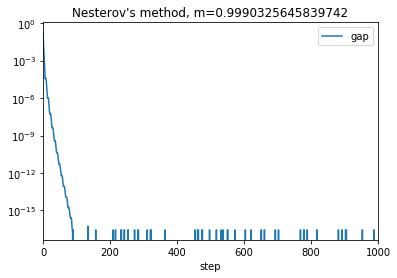

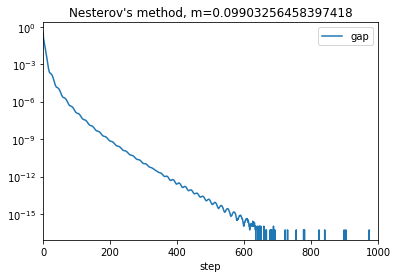

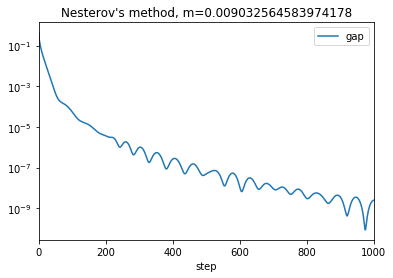

In [12]:
def nesterov(m, x_0 = np.zeros(n), max_step = 1000, f=f, L0=L0, m0=m0, gradient=gradient, minima=3):
    a = 1
    x = x_0
    #m = m0 + m
    L = L0 + m
    fx = [f(x, m)] if minima == 3 else [f(x,m)[0]]
    i = 0
    v = x - gradient(x,m)/L
    A_ = a
    y = [v]
    while True:
        i = i + 1
        a = (i+2)/2
        A = A_ + a
        x = A_/A*y[-1] + a/A*v
        y.append(x-gradient(x,m)/L)
        v = v - a*gradient(x,m)/L
        fx.append(f(y[-1],m)) if minima == 3 else fx.append(f(y[-1],m)[0])
        A_ = A
        if i >= max_step: # or (fx[i] - fx[i-1])**2 < epsilon
            minima = minimum(m)[1] if minima == 3 else np.float64(0)
            plt = pd.DataFrame({'step': list(range(0,i+1)), 'gap': fx-minima})
            plt.plot.line(x ='step', y = 'gap', logy= True, title = "Nesterov's method, m="+str(m-m0))
            return plt
agd_plot = []
for m in [1,0.1,0.01]:
    agd_plot.append(nesterov(m=m))

,step,gap
0,0,4.524375e-01
1,1,1.997176e-01
2,2,1.635905e-01
3,3,1.338099e-01
4,4,1.098384e-01
...,...,...
996,996,5.090119e-08
997,997,4.841587e-08
998,998,4.570990e-08
999,999,4.281992e-08


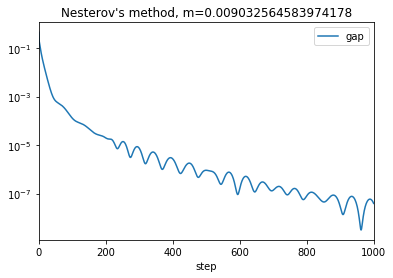

In [22]:
AGD(0.01)

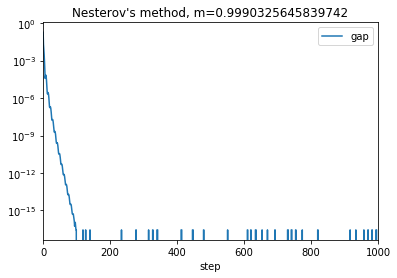

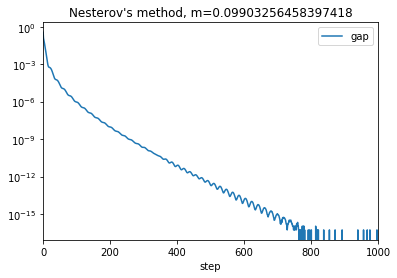

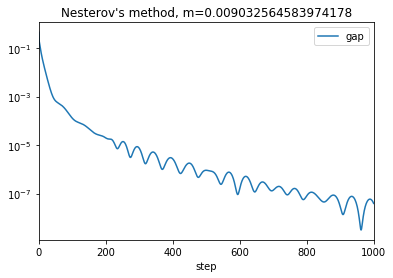

In [20]:
def AGD(m,N=1000):
    x0 = np.repeat(0,n)
    L = 4 + m
    y0 = x0 - 1/L*gradient(x0,m)
    v0 = y0
    value = [f(x0,m)]
    x_old = x0
    y_old = y0
    v_old = v0
    x_star,f_star = minimum(m)
    for i in np.arange(1,N+1):
        a = np.arange(1,i+1/2,1/2)
        A = a.sum()
        
        x_new = (A-a[-1])/A*y_old + a[-1]/A*v_old
        y_new = x_new - 1/L*gradient(x_new,m)
        v_new = v_old - a[-1]/L*gradient(x_new,m)
        
        value.append(f(y_new,m))
        x_old = x_new; y_old = y_new; v_old = v_new
    plt = pd.DataFrame({'step': list(range(0,i+1)), 'gap': value-f_star})
    #plt.plot.line(x ='step', y = 'gap', logy= True, title = "Nesterov's method, m="+str(m-m0))
    return plt
    # return y_new, value

            
agd_plot = []
for m in [1,0.1,0.01]:
    agd_plot.append(AGD(m=m))


In [19]:
agd_plot[1].head()

,step,gap
0,0,0.364922
1,1,0.122437
2,2,0.090416
3,3,0.065261
4,4,0.046235


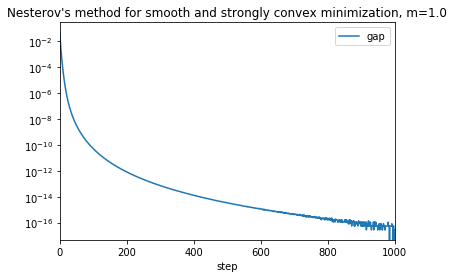

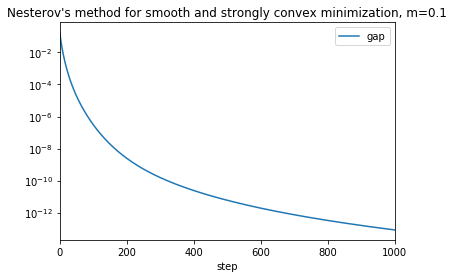

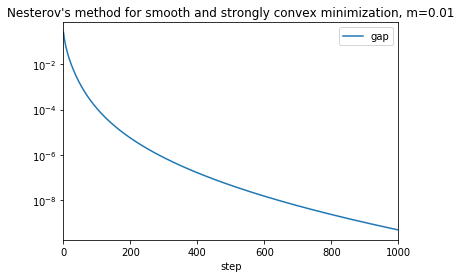

In [9]:
def agd_strong(m, x_0 = np.zeros(n), epsilon=10**(-20), max_step = 1000, minima=3):
    x = x_0
    m = m0 + m
    L = L0 + m
    a = 1
    A = a
    v = x-gradient(x,m)/L
    y = v
    fx = [f(y,m)]
    i = 0
    while True:
        i = i + 1
        a = (i+2)/2
        A = a+A
        # a_ = (L-m+m*(A-a))/(L-m+m*A)*a
        theta = (A-a)/(A-a + (L-m+m*(A-a))/(L-m+m*A)*a)
        # theta = 1- a_/(A-a+a_)
        x = theta*y+(1-theta)*v
        v = (L-m+m*(A-a))/(L-m+m*A)*v + m*a/(L-m+m*A)*x - a/(L-m+m*A)*gradient(x,m)
        y = x - gradient(x,m)/L
        fx.append(f(y,m))
        if i >= max_step: 
            minima = minimum(m)[1] if minima==3 else 0
            plt = pd.DataFrame({'step': list(range(0,i+1)), 'gap': fx-minima})
            plt.plot.line(x ='step', y = 'gap', logy= True, title = "Nesterov's method for smooth and strongly convex minimization, m="+str(m-m0))
            return plt
agdsc_plot = []
for m in [1,0.1,0.01]:
    agdsc_plot.append(agd_strong(m=m))

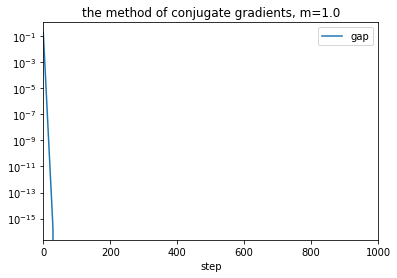

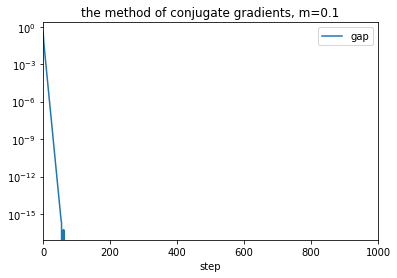

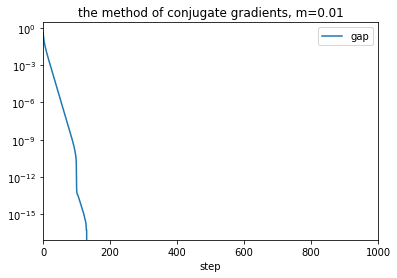

In [8]:
def cg(m, x_0 = np.zeros(n), epsilon=10**(-20), max_step = 1000):
    x = x_0
    fx = [f(x,m)]
    i = 0
    p = gradient(x,m)
    m = m+m0
    while True:
        i = i + 1
        gradient_old = gradient(x,m)
        h = gradient_old.dot(p)/np.dot(M.dot(p), p)
        x = x - h*p
        gradient_new = gradient(x,m)
        p = gradient_new - np.linalg.norm(gradient_new)**2*p/p.dot(gradient_new-gradient_old)
        fx.append(f(x,m))
        if i >= max_step: # or (fx[i] - fx[i-1])**2 < epsilon
            minima = minimum(m)[1]
            plt = pd.DataFrame({'step': list(range(0,i+1)), 'gap': fx-minima})
            plt.plot.line(x ='step', y = 'gap', logy= True, title = "the method of conjugate gradients, m="+str(m-m0))
            return plt
cg_plot = []
for m in [1,0.1,0.01]:
    cg_plot.append(cg(m=m))

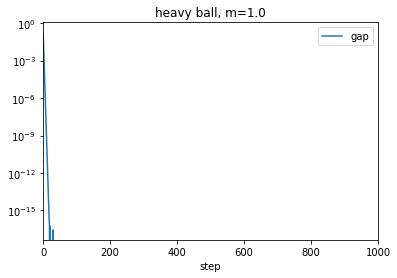

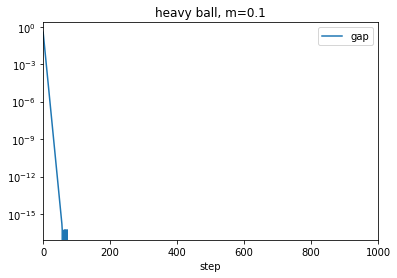

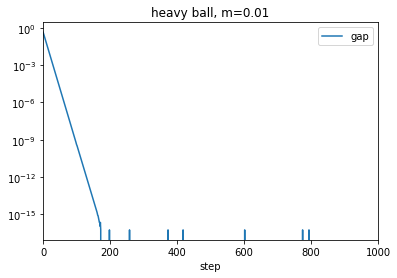

In [9]:
def heavy_ball(m, x_0 = np.zeros(n), max_step = 1000, f=f, L0=L0, m0=m0, gradient=gradient, minima=3):
    x_k = x_0
    m = m0 + m
    L = L0 + m
    alpha1 = 4/((L**.5+m**.5)**2)
    alpha2 = ((L**.5-m**.5)/(L**.5+m**.5))**2
    x_k_1 = x_k
    fx = [f(x_k,m)] if minima == 3 else [f(x_k,m)[0]]
    i = 0
    while True:
        i = i + 1
        x = x_k-alpha1*gradient(x_k,m)+alpha2*(x_k-x_k_1)
        x_k_1 = x_k
        x_k = x 
        fx.append(f(x,m)) if minima == 3 else fx.append(f(x,m)[0])
        if i >= max_step: # or (fx[i] - fx[i-1])**2 < epsilon
            minima = minimum(m)[1] if minima == 3 else np.float64(0)
            plt = pd.DataFrame({'step': list(range(0,i+1)), 'gap': fx-minima})
            plt.plot.line(x ='step', y = 'gap', logy= True, title = 'heavy ball, m='+str(m-m0))
            return plt
hb_plot = []
for m in [1,0.1,0.01]:
    hb_plot.append(heavy_ball(m=m))

### 3.5 Answer the first question

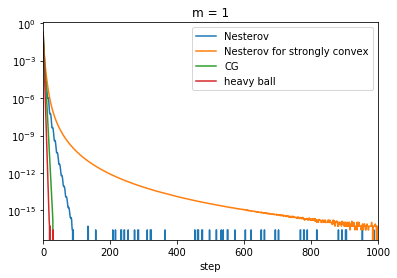

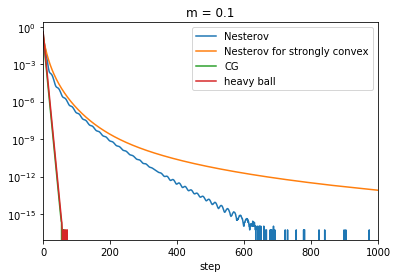

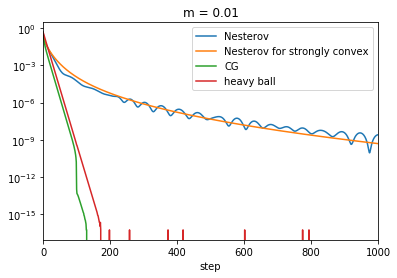

In [10]:
for i in range(3):
    plt = pd.concat([agd_plot[i], agdsc_plot[i].gap, cg_plot[i].gap, hb_plot[i].gap], axis=1, sort=False)
    plt.columns = ['step', 'Nesterov', 'Nesterov for strongly convex', 'CG', 'heavy ball']
    plt.plot.line(x = 'step', logy=True, title='m = %s' % str([1,0.1,0.01][i]))

### 3.6 Modify Nesterov's method

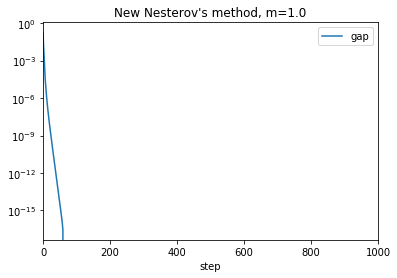

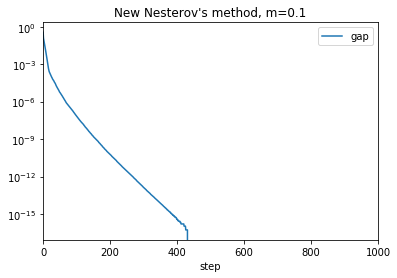

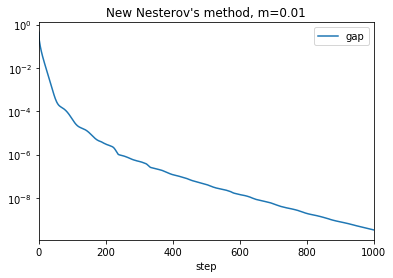

In [160]:
def nesterov_new(m, x_0 = np.zeros(n), epsilon=10**(-20), max_step = 1000):
    a = 1
    x = x_0
    fx = [f(x,m)]
    m = m0 + m
    L = L0 + m
    i = 0
    v = x - gradient(x,m)/L
    A_ = a
    y = [v]
    fxmin = [f(x,m)]
    while True:
        i = i + 1
        a = (i+2)/2
        A = A_ + a
        x = A_/A*y[-1] + a/A*v
        y.append(x-gradient(x,m)/L) if f(x-gradient(x,m)/L, m) < f(y[-1]-gradient(y[-1],m)/L, m) else y.append(y[-1]-gradient(y[-1],m)/L)
        v = v - a*gradient(x,m)/L
        fxmin.append(min(f(y[-1],m), fxmin[-1]))
        fx.append(f(y[-1],m))
        A_ = A
        if i >= max_step: # or (fx[i] - fx[i-1])**2 < epsilon
            minima = minimum(m)[1]
            plt = pd.DataFrame({'step': list(range(0,i+1)), 'gap': fxmin-minima})
            plt.plot.line(x ='step', y = 'gap', logy= True, title = "New Nesterov's method, m="+str(m-m0))
            return plt
agd_new_plot = []
for m in [1,0.1,0.01]:
    agd_new_plot.append(nesterov_new(m=m))

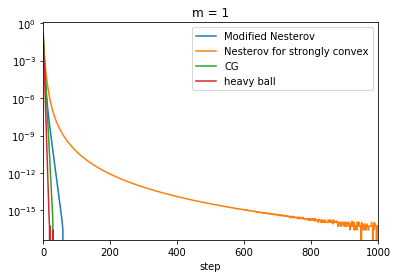

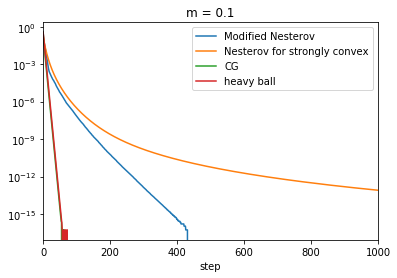

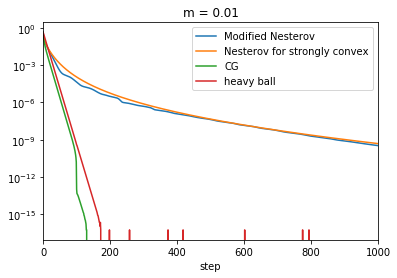

In [162]:
for i in range(3):
    plt = pd.concat([agd_new_plot[i], agdsc_plot[i].gap, cg_plot[i].gap, hb_plot[i].gap], axis=1, sort=False)
    plt.columns = ['step', 'Modified Nesterov', 'Nesterov for strongly convex', 'CG', 'heavy ball']
    plt.plot.line(x = 'step', logy=True, title='m = %s' % str([1,0.1,0.01][i]))

# Question 4

In [53]:
def f4(x,m):
    if x<1:
        return 25*x**2/2
    elif 1<=x<2:
        return x**2/2+24*x-12
    else:
        return 25*x**2/2-24*x+36

def gradient4(x,m):
    if x<1:
        return 25*x
    elif 1<=x<2:
        return x+24
    else:
        return 25*x-24

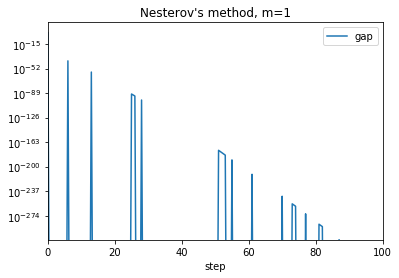

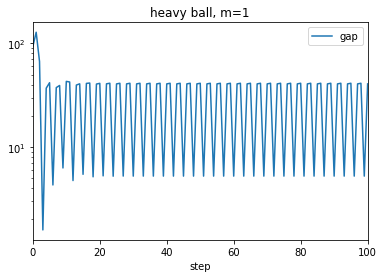

In [152]:
nesterov(m=1,x_0=np.array([3.3]),f=f4,L0=24,m0=0,gradient=gradient4,minima=4,max_step=100)
heavy_ball(m=1,x_0=np.array([3.3]),f=f4,L0=24,m0=0,gradient=gradient4,minima=4,max_step=100)
None